# Determine P-value threshold at chosen a FDR threshold

In this notebook, we describe how to determine a P-value threshold for a given dataset so that the FDR is kept below a chosen threshold. We use an empirical method to estimate the FDR at given P-value thresholds. For a given P-value threshold ``p_thresh``, we proceed in four steps:

1. Determine the number of significant interactions ``sig_num_o`` at ``p_thresh``.
2. Randomize the simple and twisted read pair counts of all interactions. We randomize individual interactions with $n$ read pairs by randomly drawing a simple count from a binomial distribution with $p=0.5$ and then setting the twisted count to $t=n-s$.
3. Determine the number of randomized significant interactions ``sig_num_r`` at ``p_thresh``.
4. Use ``sig_num_r/sig_num_o`` to estimate the FDR at ``p_thresh``.

To find a P-value threshold for which the FDR is kept below a chosen threshold, we estimate the FDR for increasing P-value thresholds. Then we use the largest P-value threshold for which the FDR is still below the chosen threshold. Note that we randomize each interaction only once and then use the same list of P-values of randomized interactions for all P-value thresholds.

Usually the FDR grows monotonically with the P-value threshold. However, for datasets with poor signal-to-noise ratio, this may not be the case. Therefore we check this and issue a warning if applicable.

## Setting up the notebook

In [1]:
import sys
import os
from numpy import arange
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import RandomizeInteractionSet

In this notebook, we use the following classes:
- ``DiachromaticInteractionSet``
- ``RandomizeInteractionSet``

We use the ``DiachromaticInteractionSet`` to read, evaluate, categorize and write interactions to a file. The randomization analyzes are carried out in class ``RandomizeInteractionSet``, which operates on an already existing ``DiachromaticInteractionSet`` object that has been passed to its constructor.

## Test files

### Test file 1

The purpose of the first test file is to check whether the P-value thresholds are used correctly during the FDR analysis. The function ``write_diachromatic_interaction_fdr_test_file`` of class ``DiachromaticInteractionSet`` can be used to generate a test file that contains the same number of interactions for consecutive P-value intervals of the same size. The following parameters must be specified:

- maximum P-value
- P-value step size
- requested number of interactions per interval
- input interaction file
- output interaction file

Make sure that the interaction file has not previously been categorized with a P-value threshold that is smaller than the specified maximum P-value. Otherwise, interactions that do not have enough read pairs to be significant at the smaller threshold may have already been discarded.

The maximum P-value and the step size are used to create a list of ascendingly sorted P-values that define intervals of equal size.

In [2]:
p_value_max = 0.05
p_value_step = 0.0025
p_threshs = arange(p_value_step, p_value_max + p_value_step, p_value_step)
print(p_threshs)

[0.0025 0.005  0.0075 0.01   0.0125 0.015  0.0175 0.02   0.0225 0.025
 0.0275 0.03   0.0325 0.035  0.0375 0.04   0.0425 0.045  0.0475 0.05  ]


And for each of these intervals, the requested number of interactions is selected from the input file and written into a new interaction file that can be used for testing.

In order to create a test file for the FDR module, we first read an interactions file from real data into a ``DiachromaticInteractionSet``.

In [5]:
interaction_input_file = '../tests/data/test_03/MK_0.06_evaluated_and_categorized_interactions.tsv.gz'
interaction_set_test = DiachromaticInteractionSet()
interaction_set_test.parse_file(interaction_input_file, verbose=False)
#read_file_info_report = interaction_set_test.get_read_file_info_report()
#print(read_file_info_report)

Then we create the test file with the function provided for this purpose.

In [6]:
write_test_file_info_dict = interaction_set_test.write_diachromatic_interaction_fdr_test_file(
    target_file='../tests/data/test_03/diachromatic_interaction_file_fdr_1.tsv',
    p_value_max = 0.05,
    p_value_step = 0.00025,
    i_per_interval_requested = 10,   
    verbose=True)

[INFO] Generating test file for FDR procedure ...
	[INFO] Iterating interaction set and writing interactions to test file ...
[INFO] ... done.


The function creates the new interaction file for testing and returns a table containing the number of selected interactions for each P-value interval. For the parameters given above, this table has rows for 200 intervals. For each interval, the current and cumulative number of selected interactions is reported.

In [7]:
pandas.set_option('display.max_rows', None)
pandas.DataFrame(write_test_file_info_dict['RESULTS_TABLE'])

,PVAL_INTERVAL,I_SELECTED,I_SELECTED_CUM
0,]0.00000;0.00025],10,10
1,]0.00025;0.00050],10,20
2,]0.00050;0.00075],10,30
3,]0.00075;0.00100],10,40
4,]0.00100;0.00125],10,50
5,]0.00125;0.00150],10,60
6,]0.00150;0.00175],10,70
7,]0.00175;0.00200],10,80
8,]0.00200;0.00225],10,90
9,]0.00225;0.00250],10,100


In this case, the requested number of 10 interactions could be selected for each of the 200 P-value intervals so that the output file contains 2000 interactions.

### Test files 2

To investigate the influence of the total number of input interactions on the estimation of the FDR, we created smaller files from a real interaction file by writing the top lines to new files. We have prepared test files with 1000, 10000, 100000, 1000000, 2000000, 4000000 and 8000000 interactions. Because of the file sizes, we have only added the first three files to this repository.

In [8]:
ls ../tests/data/test_03/*top*

../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_10000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_100000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_2000000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_4000000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000000.tsv.gz


## Check that P-value thresholds are being used  correctly

During the FDR procedure, the number of sigificant interactions is determined at different P-value thresholds. In addition, P-values and logarithmized P-values are used. This can lead to errors when usinng ``<``, ``<=``, ``>`` or ``>=``. Furthermore, the transformations log(p) and exp(log(p)) can lead to inaccuracies. To check whether the thresholds are being used  correctly, we apply our FDR procedure to the test file, which contains the same number of interactions for different P-value intervals.

First, we read the test file into an ``DiachromaticInteractionSet``. When creating this file, we have defined 200 intervals and selected 10 interactions for each interval. Therefore, we expect a total of 2000 interactions.

In [2]:
interaction_set = DiachromaticInteractionSet()
interaction_set.parse_file('../tests/data/test_03/diachromatic_interaction_file_fdr_1.tsv', verbose=False)
read_file_info_report = interaction_set.get_read_file_info_report()
print(read_file_info_report)

[INFO] Report on reading files:
	[INFO] Read interaction data from 1 files:
		[INFO] 2000 interactions from: 
			[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_1.tsv
			[INFO] Set size: 2000
	[INFO] The interaction set has 2000 interactions.
[INFO] End of report.



Then we create an object of class ``RandomizeInteractionSet`` and, at the same time, pass the interaction set to this object. Finally, we call the function for the FDR procedure. We use the same values for the maximum P-value (``pval_thresh_max``) and the step size (``pval_thresh_step_size``) that we used when creating the test file.

In [3]:
randomize_fdr = RandomizeInteractionSet(interaction_set=interaction_set)
fdr_info_dict = randomize_fdr.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh = 0.05,
    pval_thresh_max = 0.05,
    pval_thresh_step_size = 0.00025,
    verbose = True)

[INFO] Performing FDR procedure ...
	[INFO] Getting list of observed P-values ...
	[INFO] Getting list of randomized P-values ...
	[INFO] Going through list of P-value thresholds and estimate FDR ...
	[INFO] Looking for largest P-value threshold for which the FDR is below the chosen threshold ...
		[INFO] P-value threshold: 0.00025
		[INFO] -ln(P-value) threshold: 8.29405
		[INFO] Number of randomized significant interactions: 0
		[INFO] Number of observed significant interactions: 10
		[INFO] Estimated FDR: 0.00000
[INFO] ... done.


../diachr/randomize_interaction_set.py:109: UserWarning: FDR did not grow monotonically with P-value threshold!
Take a close look at the results for each of the P-value thresholds.
  warnings.warn("FDR did not grow monotonically with P-value threshold!" + '\n' + \


For this example, a warning is issued because the FDR did not grow monotonically with the P-value thresholds. In such cases, the determined P-value threshold and the associated estimated FDR are not valid, which is to be expected for this test dataset.

We created this test file to test that the various P-value thresholds are used correctly. The function for the FDR procedure returns a table containing the results for all P-value thresholds. This table has the following columns:

- ``P_VAL_TRESH``: P-value threshold
- ``NNL_P_VAL_TRESH``: Negative of the natural logarithm of the P-value threshold
- ``SIG_NUM_R``: Number of randomized significant interactions
- ``SIG_NUM_O``: Number of observed significant interaction
- ``FDR``: Estimated FDR

Run the cell below to display this table.

In [4]:
pandas.set_option('display.max_rows', None)
pandas.DataFrame(fdr_info_dict['RESULTS_TABLE'])

,PVAL_TRESH,NNL_PVAL_TRESH,MIN_RP_NUM,MIN_RP_NUM_PVAL,SIG_NUM_R,SIG_NUM_O,FDR
0,0.00025,8.294050,13,0.000244,0,10,0.000000
1,0.00050,7.600902,12,0.000488,2,20,0.100000
2,0.00075,7.195437,12,0.000488,2,30,0.066667
3,0.00100,6.907755,11,0.000977,3,40,0.075000
4,0.00125,6.684612,11,0.000977,4,50,0.080000
5,0.00150,6.502290,11,0.000977,4,60,0.066667
6,0.00175,6.348139,11,0.000977,4,70,0.057143
7,0.00200,6.214608,10,0.001953,4,80,0.050000
8,0.00225,6.096825,10,0.001953,4,90,0.044444
9,0.00250,5.991465,10,0.001953,5,100,0.050000


In the number of significant interactions in column ``SIG_NUM_O`` increases by 10 for each P-value threshold. This is what we expect for this test dataset and we are testing this in a unit test. 

In [7]:
import seaborn as sns

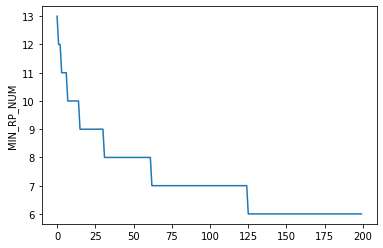

In [8]:
fdr_df = pandas.DataFrame(fdr_info_dict['RESULTS_TABLE'])
fdr_df.head()
sns.lineplot(data=fdr_df, x=range(0,200), y="MIN_RP_NUM")

## Influence of the total number of interactions on the estimation of the FDR

XXX

In [2]:
import sys
import os
from numpy import arange, exp, log
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import RandomizeInteractionSet

In [3]:
interaction_file_top_1000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000.tsv.gz'
interaction_file_top_10000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_10000.tsv.gz'
interaction_file_top_100000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_100000.tsv.gz'
interaction_file_top_1000000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000000.tsv.gz'
interaction_file_top_2000000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_2000000.tsv.gz'
interaction_file_top_4000000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_4000000.tsv.gz'
interaction_file_top_8000000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000000.tsv.gz'

In [4]:
interaction_set_top_1000 = DiachromaticInteractionSet()
interaction_set_top_1000.parse_file(interaction_file_top_1000, verbose=True)

interaction_set_top_10000 = DiachromaticInteractionSet()
interaction_set_top_10000.parse_file(interaction_file_top_10000, verbose=True)

interaction_set_top_100000 = DiachromaticInteractionSet()
interaction_set_top_100000.parse_file(interaction_file_top_100000, verbose=True)

interaction_set_top_1000000 = DiachromaticInteractionSet()
interaction_set_top_1000000.parse_file(interaction_file_top_1000000, verbose=True)

interaction_set_top_2000000 = DiachromaticInteractionSet()
interaction_set_top_2000000.parse_file(interaction_file_top_2000000, verbose=True)

interaction_set_top_4000000 = DiachromaticInteractionSet()
interaction_set_top_4000000.parse_file(interaction_file_top_4000000, verbose=True)

interaction_set_top_8000000 = DiachromaticInteractionSet()
interaction_set_top_8000000.parse_file(interaction_file_top_8000000, verbose=True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000.tsv.gz
[INFO] ... done.
[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_10000.tsv.gz
[INFO] ... done.
[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_100000.tsv.gz
[INFO] ... done.
[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000000.tsv.gz
	[INFO] Parsed 1000000 interaction lines ...
[INFO] ... done.
[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_2000000.tsv.gz
	[INFO] Parsed 1000000 interaction lines ...
	[INFO] Parsed 2000000 interaction lines ...
[INFO] ... done.
[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_4000000.t

In [5]:
randomize_fdr_top_1000 = RandomizeInteractionSet(interaction_set=interaction_set_top_1000)
randomize_fdr_top_10000 = RandomizeInteractionSet(interaction_set=interaction_set_top_10000)
randomize_fdr_top_100000 = RandomizeInteractionSet(interaction_set=interaction_set_top_100000)
randomize_fdr_top_1000000 = RandomizeInteractionSet(interaction_set=interaction_set_top_1000000)
randomize_fdr_top_2000000 = RandomizeInteractionSet(interaction_set=interaction_set_top_2000000)
randomize_fdr_top_4000000 = RandomizeInteractionSet(interaction_set=interaction_set_top_4000000)
randomize_fdr_top_8000000 = RandomizeInteractionSet(interaction_set=interaction_set_top_8000000)

In [6]:
chosen_fdr_thresh = 0.05
p_value_max = 0.05
p_value_step = 0.00025

In [11]:
fdr_info_dict_top_1000 = randomize_fdr_top_1000.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh=chosen_fdr_thresh,
    pval_thresh_max=p_value_max,
    pval_thresh_step_size=p_value_step)

pandas.DataFrame(fdr_info_dict_top_1000['RESULTS_TABLE']).loc[fdr_info_dict_top_1000['ROW_INDEX'][0],:]

../diachr/randomize_interaction_set.py:102: UserWarning: FDR did not grow monotonically with P-value threshold!
Take a close look at the results for each of the P-value thresholds.
  warnings.warn("FDR did not grow monotonically with P-value threshold!" + '\n' + \


P_VAL_TRESH         0.007500
NNL_P_VAL_TRESH     4.892852
SIG_NUM_R           1.000000
SIG_NUM_O          26.000000
FDR                 0.038462
Name: 29, dtype: float64

In [12]:
fdr_info_dict_top_10000 = randomize_fdr_top_10000.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh=chosen_fdr_thresh,
    pval_thresh_max=p_value_max,
    pval_thresh_step_size=p_value_step)

pandas.DataFrame(fdr_info_dict_top_10000['RESULTS_TABLE']).loc[fdr_info_dict_top_10000['ROW_INDEX'][0],:]

../diachr/randomize_interaction_set.py:102: UserWarning: FDR did not grow monotonically with P-value threshold!
Take a close look at the results for each of the P-value thresholds.
  warnings.warn("FDR did not grow monotonically with P-value threshold!" + '\n' + \


P_VAL_TRESH          0.003500
NNL_P_VAL_TRESH      5.654992
SIG_NUM_R           10.000000
SIG_NUM_O          212.000000
FDR                  0.047170
Name: 13, dtype: float64

In [13]:
fdr_info_dict_top_100000 = randomize_fdr_top_100000.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh=chosen_fdr_thresh,
    pval_thresh_max=p_value_max,
    pval_thresh_step_size=p_value_step)

pandas.DataFrame(fdr_info_dict_top_100000['RESULTS_TABLE']).loc[fdr_info_dict_top_100000['ROW_INDEX'][0],:]

../diachr/randomize_interaction_set.py:102: UserWarning: FDR did not grow monotonically with P-value threshold!
Take a close look at the results for each of the P-value thresholds.
  warnings.warn("FDR did not grow monotonically with P-value threshold!" + '\n' + \


P_VAL_TRESH           0.003750
NNL_P_VAL_TRESH       5.585999
SIG_NUM_R           106.000000
SIG_NUM_O          2477.000000
FDR                   0.042794
Name: 14, dtype: float64

In [14]:
fdr_info_dict_top_1000000 = randomize_fdr_top_1000000.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh=chosen_fdr_thresh,
    pval_thresh_max=p_value_max,
    pval_thresh_step_size=p_value_step)

pandas.DataFrame(fdr_info_dict_top_1000000['RESULTS_TABLE']).loc[fdr_info_dict_top_1000000['ROW_INDEX'][0],:]

../diachr/randomize_interaction_set.py:102: UserWarning: FDR did not grow monotonically with P-value threshold!
Take a close look at the results for each of the P-value thresholds.
  warnings.warn("FDR did not grow monotonically with P-value threshold!" + '\n' + \


P_VAL_TRESH            0.003750
NNL_P_VAL_TRESH        5.585999
SIG_NUM_R           1189.000000
SIG_NUM_O          24181.000000
FDR                    0.049171
Name: 14, dtype: float64

In [15]:
fdr_info_dict_top_2000000 = randomize_fdr_top_2000000.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh=chosen_fdr_thresh,
    pval_thresh_max=p_value_max,
    pval_thresh_step_size=p_value_step)

pandas.DataFrame(fdr_info_dict_top_2000000['RESULTS_TABLE']).loc[fdr_info_dict_top_2000000['ROW_INDEX'][0],:]

../diachr/randomize_interaction_set.py:102: UserWarning: FDR did not grow monotonically with P-value threshold!
Take a close look at the results for each of the P-value thresholds.
  warnings.warn("FDR did not grow monotonically with P-value threshold!" + '\n' + \


P_VAL_TRESH            0.003750
NNL_P_VAL_TRESH        5.585999
SIG_NUM_R           2330.000000
SIG_NUM_O          49074.000000
FDR                    0.047479
Name: 14, dtype: float64

In [16]:
fdr_info_dict_top_4000000 = randomize_fdr_top_4000000.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh=chosen_fdr_thresh,
    pval_thresh_max=p_value_max,
    pval_thresh_step_size=p_value_step)

pandas.DataFrame(fdr_info_dict_top_4000000['RESULTS_TABLE']).loc[fdr_info_dict_top_4000000['ROW_INDEX'][0],:]

../diachr/randomize_interaction_set.py:102: UserWarning: FDR did not grow monotonically with P-value threshold!
Take a close look at the results for each of the P-value thresholds.
  warnings.warn("FDR did not grow monotonically with P-value threshold!" + '\n' + \


P_VAL_TRESH            0.003750
NNL_P_VAL_TRESH        5.585999
SIG_NUM_R           4629.000000
SIG_NUM_O          98139.000000
FDR                    0.047168
Name: 14, dtype: float64

In [17]:
pandas.set_option('display.max_rows', None)
pandas.DataFrame(fdr_info_dict_top_4000000['RESULTS_TABLE'])

,P_VAL_TRESH,NNL_P_VAL_TRESH,SIG_NUM_R,SIG_NUM_O,FDR
0,0.00025,8.294050,240,48398,0.004959
1,0.00050,7.600902,506,56798,0.008909
2,0.00075,7.195437,735,61954,0.011864
3,0.00100,6.907755,1201,68994,0.017407
4,0.00125,6.684612,1335,71036,0.018793
5,0.00150,6.502290,1658,74983,0.022112
6,0.00175,6.348139,1879,77418,0.024271
7,0.00200,6.214608,2587,83224,0.031085
8,0.00225,6.096825,2797,85162,0.032843
9,0.00250,5.991465,3176,88147,0.036031


In [8]:
p_value_max = 0.025
fdr_info_dict_top_8000000 = randomize_fdr_top_8000000.get_pval_tresh_at_chosen_fdr_tresh(
    chosen_fdr_thresh=chosen_fdr_thresh,
    pval_thresh_max=p_value_max,
    pval_thresh_step_size=p_value_step)

pandas.DataFrame(fdr_info_dict_top_8000000['RESULTS_TABLE']).loc[fdr_info_dict_top_8000000['RESULT_INDEX'][0],:]

PVAL_THRESH             0.003750
NNL_PVAL_THRESH         5.585999
MIN_RP_NUM             10.000000
MIN_RP_NUM_PVAL         0.001953
SIG_NUM_R            9400.000000
SIG_NUM_O          196005.000000
FDR                     0.047958
Name: 14, dtype: float64

In [9]:
pandas.set_option('display.max_rows', None)
pandas.DataFrame(fdr_info_dict_top_8000000['RESULTS_TABLE'])

,PVAL_THRESH,NNL_PVAL_THRESH,MIN_RP_NUM,MIN_RP_NUM_PVAL,SIG_NUM_R,SIG_NUM_O,FDR
0,0.00025,8.294050,13,0.000244,446,96797,0.004608
1,0.00050,7.600902,12,0.000488,1014,113597,0.008926
2,0.00075,7.195437,12,0.000488,1483,123968,0.011963
3,0.00100,6.907755,11,0.000977,2537,137908,0.018396
4,0.00125,6.684612,11,0.000977,2771,141973,0.019518
5,0.00150,6.502290,11,0.000977,3439,149746,0.022966
6,0.00175,6.348139,11,0.000977,3865,154593,0.025001
7,0.00200,6.214608,10,0.001953,5324,166225,0.032029
8,0.00225,6.096825,10,0.001953,5729,170125,0.033675
9,0.00250,5.991465,10,0.001953,6488,175980,0.036868


In [10]:
fdr_list = fdr_info_dict_top_8000000['RESULTS_TABLE']['FDR']
previous_fdr = fdr_list[0]
for current_fdr in fdr_list:
    if current_fdr < previous_fdr:
        print(current_fdr)
        
#all(x>=y for x, y in zip(fdr_list,fdr_list[1:]))

for x, y in zip(fdr_list,fdr_list[1:]):
    if x>y:
        print(str(x) + '\t' + str(y))

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
fdr_info_dict_top_8000000['INPUT_PARAMETERS']

{'CHOSEN_FDR_THRESH': [0.05],
 'PVAL_THRESH_MAX': [0.025],
 'PVAL_THRESH_STEP_SIZE': [0.00025]}

/Users/hansep/anaconda2/envs/diachscripts_p37env/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


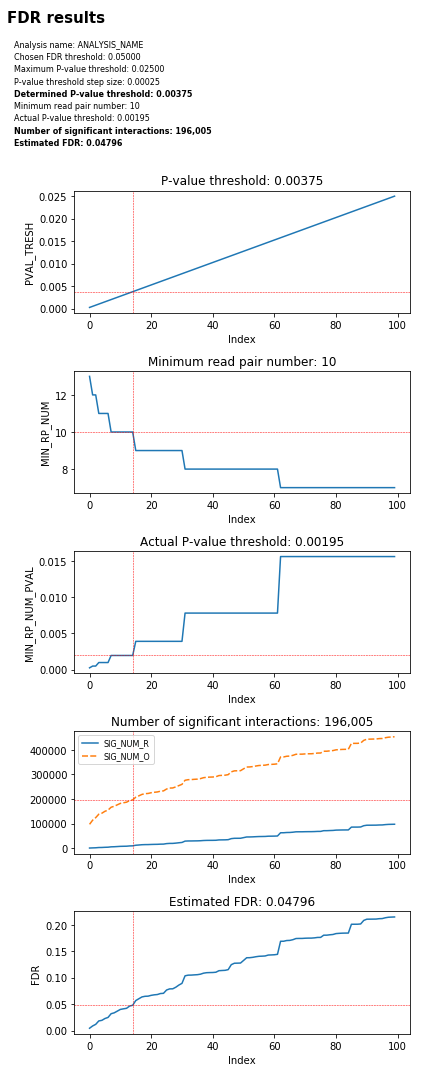

In [33]:
# Set parameters
pdf_filename = 'foo.pdf'
analysis_name = 'ANALYSIS_NAME'
hv_lwd = 0.5     # line width of horizontal and vertical red dashed lines
hv_col = 'red'   # color of horizontal and vertical red dashed lines

# Extract data from fdr_info_dict
chosen_fdr_thresh = fdr_info_dict_top_8000000['INPUT_PARAMETERS']['CHOSEN_FDR_THRESH'][0]
pval_thresh_max = fdr_info_dict_top_8000000['INPUT_PARAMETERS']['PVAL_THRESH_MAX'][0]
pval_thresh_step_size = fdr_info_dict_top_8000000['INPUT_PARAMETERS']['PVAL_THRESH_STEP_SIZE'][0]
result_index = fdr_info_dict_top_8000000['RESULT_INDEX'][0]

fdr_df = pandas.DataFrame(fdr_info_dict_top_8000000['RESULTS_TABLE'])

pval_thresh_column = fdr_info_dict_top_8000000['RESULTS_TABLE']['PVAL_THRESH']
pval_thresh_result = fdr_info_dict_top_8000000['RESULTS_TABLE']['PVAL_THRESH'][result_index]
min_rp_num_column = fdr_info_dict_top_8000000['RESULTS_TABLE']['MIN_RP_NUM']
min_rp_num_result = fdr_info_dict_top_8000000['RESULTS_TABLE']['MIN_RP_NUM'][result_index]
min_rp_num_pval_column = fdr_info_dict_top_8000000['RESULTS_TABLE']['MIN_RP_NUM_PVAL']
min_rp_num_pval_result = fdr_info_dict_top_8000000['RESULTS_TABLE']['MIN_RP_NUM_PVAL'][result_index]
sig_num_o_column = fdr_info_dict_top_8000000['RESULTS_TABLE']['SIG_NUM_O']
sig_num_o_result = fdr_info_dict_top_8000000['RESULTS_TABLE']['SIG_NUM_O'][result_index]
sig_num_r_column = fdr_info_dict_top_8000000['RESULTS_TABLE']['SIG_NUM_R']
sig_num_r_result = fdr_info_dict_top_8000000['RESULTS_TABLE']['SIG_NUM_R'][result_index]
fdr_column = fdr_info_dict_top_8000000['RESULTS_TABLE']['FDR']
fdr_result = fdr_info_dict_top_8000000['RESULTS_TABLE']['FDR'][result_index]

# Create figure with plots for individual columns
fig, ax = plt.subplots(6, figsize=(6,15))

# Add field with information about analysis
plt.plot(ax=ax[0])
ax[0].spines['left'].set_color('white')
ax[0].spines['right'].set_color('white')
ax[0].spines['top'].set_color('white')
ax[0].spines['bottom'].set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].text(-0.2,0.9,'FDR results',fontsize=15, fontweight='bold')
ax[0].text(-0.18,0.7,'Analysis name: ' + analysis_name, fontsize=8)
ax[0].text(-0.18,0.6,'Chosen FDR threshold: ' + "{:.5f}".format(chosen_fdr_thresh), fontsize=8)
ax[0].text(-0.18,0.5,'Maximum P-value threshold: ' + "{:.5f}".format(pval_thresh_max), fontsize=8)
ax[0].text(-0.18,0.4,'P-value threshold step size: ' + "{:.5f}".format(pval_thresh_step_size), fontsize=8)
ax[0].text(-0.18,0.3,'Determined P-value threshold: ' + "{:.5f}".format(pval_thresh_result), fontsize=8, fontweight='bold')
ax[0].text(-0.18,0.2,'Minimum read pair number: ' + str(min_rp_num_result), fontsize=8)
ax[0].text(-0.18,0.1,'Actual P-value threshold: ' + "{:.5f}".format(min_rp_num_pval_result), fontsize=8)
ax[0].text(-0.18,0.0,'Number of significant interactions: ' + "{:,}".format(sig_num_o_result), fontsize=8, fontweight='bold')
ax[0].text(-0.18,-0.1,'Estimated FDR: ' + "{:.5f}".format(fdr_result), fontsize=8, fontweight='bold')

# Plot P-value thresholds
sns.lineplot(data=pval_thresh_column, ax=ax[1]).set_title('P-value threshold: ' + "{:.5f}".format(pval_thresh_result))
ax[1].set(xlabel='Index')
ax[1].set(ylabel='PVAL_TRESH')
ax[1].axhline(pval_thresh_result, linestyle='--', color=hv_col, linewidth=hv_lwd)
ax[1].axvline(result_index, linestyle='--', color=hv_col, linewidth=hv_lwd)

# Plot minimum read pair numbers
sns.lineplot(data=min_rp_num_column, ax=ax[2]).set_title('Minimum read pair number: ' + str(min_rp_num_result))
ax[2].set(xlabel='Index')
ax[2].set(ylabel='MIN_RP_NUM')
ax[2].axhline(min_rp_num_result, linestyle='--', color=hv_col, linewidth=hv_lwd)
ax[2].axvline(result_index, linestyle='--', color=hv_col, linewidth=hv_lwd)

# Plot actual P-value thresholds
sns.lineplot(data=min_rp_num_pval_column, ax=ax[3]).set_title('Actual P-value threshold: ' + "{:.5f}".format(min_rp_num_pval_result))
ax[3].set(xlabel='Index')
ax[3].set(ylabel='MIN_RP_NUM_PVAL')
ax[3].axhline(min_rp_num_pval_result, linestyle='--', color=hv_col, linewidth=hv_lwd)
ax[3].axvline(result_index, linestyle='--', color=hv_col, linewidth=hv_lwd)

# Plot number of significant interactions
sns.lineplot(data=fdr_df.iloc[:, 4:6], ax=ax[4]).set_title('Number of significant interactions: ' + "{:,}".format(sig_num_o_result))
ax[4].set(xlabel='Index')
ax[4].legend(fontsize=8)
ax[4].axhline(sig_num_o_result, linestyle='--', color=hv_col, linewidth=hv_lwd)
ax[4].axvline(result_index, linestyle='--', color=hv_col, linewidth=hv_lwd)

# Plot estimated FDR
sns.lineplot(data=fdr_column, ax=ax[5]).set_title('Estimated FDR: ' + "{:.5f}".format(fdr_result))
ax[5].set(xlabel='Index')
ax[5].set(ylabel='FDR')
ax[5].axhline(fdr_result, linestyle='--', color=hv_col, linewidth=hv_lwd)
ax[5].axvline(result_index, linestyle='--', color=hv_col, linewidth=hv_lwd)

fig.tight_layout()

fig.show()

fig.savefig(pdf_filename)


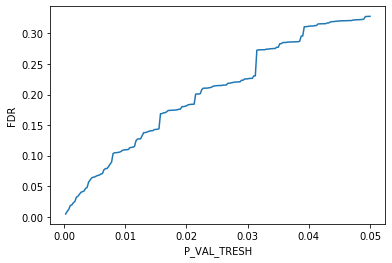

In [28]:
# Plot P-value thresholds versus FDR
sns.lineplot(data=fdr_df, x='P_VAL_TRESH', y='FDR')

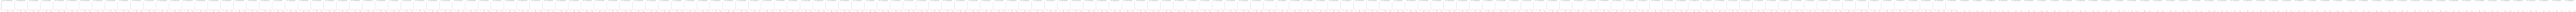

In [34]:
# Plot all columns in a FacetGrid
g = sns.FacetGrid(fdr_df, col='FDR')
g.map(sns.lineplot, 'FDR')